In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d                                  #3D繪圖
from matplotlib.colors import ListedColormap                      #建立colormap，指定每個cluster要塗甚麼顏色
from sklearn.preprocessing import StandardScaler                  #把資料做標準化
from sklearn.model_selection import train_test_split              #用來把原始樣本拆成訓練資料與測試資料
from sklearn.metrics.pairwise import pairwise_distances_argmin    #找出距離最接近的資料的index

################################################################################################################################
#以下定義一些圖示化模型時所需的方法
################################################################################################################################

#此方法是假設第0類的資料中，距離其他類資料中心最遠的那一個資料
#也就是與其他資料中心的距離和為最大者，會被正確判斷
#然後我們把該資料與第0個資料互換位置
def Data_rearrangement_farthest(X,y,n_clusters):
    n_samples=len(list(X))
    n_features=len(list(X[0]))
    #初始化資料
    A=[]
    b=[]
    #A=X[0],b=y[0]
    #如果直接這樣設定，那麼後面指定X[0]=X[index]的時候，A的值也會跟著改變
    #所以這裡就把A裡面要儲存的數值換成是str，也就類似變成了不會改變的常數
    for column in range(n_features):
        A=A+[str(X[0,column])]
    b=b+[str(y[0])]
    #############################################################################
    #找出各類資料的中心(平均)(第0類除外)
    Xmean=np.array(X[0,:]).reshape(1,-1)  #資料初始化，而且資料形狀要調整
    for cluster in range(1,n_clusters):   #第0類資料不用算進去
        mean=X[0,:]                       #資料初始化
        for column in range(n_features):
            mean[column]=np.array(X[:,column][y==cluster]).mean()
        mean=np.array(mean).reshape(1,-1) #調整資料形狀
        Xmean=np.concatenate((Xmean,mean),axis=0)
    Xmean=np.array(Xmean[1:])             #第0列不要
    #############################################################################
    #找出第0類的每個資料與各資料中心的距離和
    Distance=[0 for index in range(n_samples)]
    for index in range(n_samples):
        if(y[index]==0):                         #只需要找第0類資料與其他中心的距離和
            Sum=0
            for cluster in range(1,n_clusters):  #其他的分類中心
                distance=0
                for column in range(n_features):
                    distance=distance+(X[index,column]-Xmean[cluster-1,column])**2
                Sum=Sum+np.sqrt(distance)
            Distance[index]=Sum
    Distance=np.array(Distance)
    #############################################################################
    #找出距離和最大的資料其相對應的index
    MAX=Distance.max()
    INDEX=-1
    for index in range(n_samples):
        if(Distance[index]==MAX):
            INDEX=index
            break
    #############################################################################
    #交換資料(第0個與第INDEX個交換)
    X[0]=X[INDEX]
    y[0]=y[INDEX]
    #把剛剛建立的常數資料轉換成浮點數資料，之後才能做計算
    for column in range(n_features):
        A[column]=float(A[column])
    b[0]=float(b[0])
    X[INDEX]=A                          #交換資料數值
    y[INDEX]=b[0]                       #交換資料數值
    return X,y,INDEX
################################################################################################################################
#此方法是假設第0類的資料中心會被正確判斷
#然後我們把該資料與第0個資料互換位置
def Data_rearrangement(X,y):
    n_features=len(list(X[0]))
    #初始化資料
    X0=X[y==0]
    X0center=[]
    A=[]
    b=[]
    #A=X[0],b=y[0]
    #如果直接這樣設定，那麼後面指定X[0]=X[index]的時候，A的值也會跟著改變
    #所以這裡就把A裡面要儲存的數值換成是str，也就類似變成了不會改變的常數
    for column in range(n_features):
        A=A+[str(X[0,column])]
    b=b+[str(y[0])]
    #找出第0類資料的中心(平均)
    for column in range(n_features):
        X0center=X0center+[np.array(X[:,column][y==0]).mean()]
    X0center=np.array(X0center).reshape(1,-1)      #重新調整形狀
    number=pairwise_distances_argmin(X0center,X0)  #這裡回傳的number是X[y==0]的index，並不是在原本X裡面的index
    index=pairwise_distances_argmin(X0[number],X)  #找出最接近中心的資料位置
    X[0]=X[index]                                  #改變資料數值
    y[0]=y[index]                                  #改變資料數值
    #把剛剛建立的常數資料轉換成浮點數資料，之後才能做計算
    for column in range(n_features):
        A[column]=float(A[column])
    b[0]=float(b[0])
    X[index]=A                                     #改變資料數值
    y[index]=b                                     #改變資料數值
    return X,y
################################################################################################################################
#這個函數會把分類標籤以遞增順序重新整理，而且相同的分類就會對應到相同的數字
#此方法是建立在第0個資料有正確判斷
#如果第0個資料是判斷錯誤的，那麼此方法也會跟著出錯
def Label_redesignation(y):
    n_samples=len(list(y))
    n_clusters=np.array(y).max()+1
    Y=[None for index in range(n_samples)]
    ##############################################
    #找出分類標準=0
    Y[0]=0 #第0個資料的分類數字定義為0
    for index in range(1,n_samples):
        if(y[index]==y[0]):
            Y[index]=0
    ##############################################
    #找出其他分類標準
    global Index                                 #宣告Index為全域變數
    used_label=[y[0]]                            #紀錄已使用過的label
    for label in range(1,n_clusters):            #0號分類已使用過
        for INDEX in range(1,n_samples):         #開頭的資料已使用過
            Index=-1                             #初始化Index
            if(y[INDEX] not in used_label):      #檢查y[index]是否為已使用過的label
                Index=INDEX                      #記錄當下的index
                used_label=used_label+[y[Index]] #記錄當下的實際label
                break
        for index in range(Index,n_samples):
            if(y[index]==y[Index]):
                Y[index]=label
    return np.array(Y)
################################################################################################################################
def Difference_coloring(Y,Y_predict,color_same,color_different):
    n_samples=len(list(Y))
    color_list=[]
    for index in range(n_samples):
        if((Y-Y_predict)[index]==0):
            color_list=color_list+[color_same]
        else:
            color_list=color_list+[color_different]
    return color_list
################################################################################################################################
def Accuracy(Y,Y_predict):
    n_samples=len(list(Y))
    difference=Y-Y_predict
    Fault=0
    for index in range(n_samples):
        if(difference[index]!=0):
            Fault=Fault+1
    accuracy=(n_samples-Fault)/n_samples
    return Fault,accuracy
################################################################################################################################
def Mislabel_searching(X,Y,Y_predict):
    n_samples=len(list(Y))
    difference=Y-Y_predict
    L=[]
    for index in range(n_samples):
        if(difference[index]!=0):
            L=L+[index]
    Mislabel=[[None for column in range(len(list(X[0])))] for row in range(len(L))]
    for row in range(len(L)):
        for column in range(len(list(X[0]))):
            Mislabel[row][column]=X[L[row],column]
    Mislabel=np.array(Mislabel)
    return Mislabel,L

In [2]:
dataframe=pd.read_csv("used_car.csv")
df_raw=dataframe.copy()
df_raw.shape
#第一行:index
#第二行:brand。有71個廠牌
#第三行:currency。全都是PKR
#第四行:description。描述
#第五行:fuel_type。有6種
#第六行:item_condition。全都是used
#第七行:manufacturer。與廠牌相同
#第八行:mileage_from_odometer。里程數
#第九行:model_date。出產日期
#第十行:price。價格
#第十一行:vehicle_engine。排氣量
#第十二行:vehicle_transmission。手排與自排

(60109, 12)

In [3]:
#依據廠牌來拆分資料
brand_name=[]
df_individual={}
for brand in df_raw.loc[:]["brand"]:
    if(brand not in brand_name):
        brand_name+=[brand]
        df_individual[brand]=[]
for index in range(df_raw.shape[0]):
    df_individual[df_raw.loc[index]["brand"]]+=[df_raw.loc[index][:]]

In [4]:
#這裡取Toyota出來
Toyota=df_individual["Toyota"]

In [5]:
#把字串資料轉換成數值型態
fuel_type_name=[]
fuel_type_dict={}
for fuel_type in df_raw.loc[:]["fuel_type"]:
    if(fuel_type not in fuel_type_name):
        fuel_type_name+=[fuel_type]
for i in range(len(fuel_type_name)):
    fuel_type_dict[fuel_type_name[i]]=i
for j in range(len(Toyota)):
    Toyota[j]["fuel_type"]=fuel_type_dict[Toyota[j]["fuel_type"]]
#########################################################################################
mileage_from_odometer_name=[]
for index in range(len(Toyota)):
    mileage_from_odometer_name+=[Toyota[index]["mileage_from_odometer"][:-3]]
for index in range(len(Toyota)):
    if("," in mileage_from_odometer_name[index]):
        arr=mileage_from_odometer_name[index].split(",")
        result=""
        for char in arr:
            result+=char
        Toyota[index]["mileage_from_odometer"]=int(result)
    else:
        Toyota[index]["mileage_from_odometer"]=int(mileage_from_odometer_name[index])
#########################################################################################
for index in range(len(Toyota)):
    Toyota[index]["model_date"]=int(Toyota[index]["model_date"])
    Toyota[index]["price"]=int(Toyota[index]["price"])
#########################################################################################
vehicle_engine_name=[]
for index in range(len(Toyota)):
    num=Toyota[index]["vehicle_engine"][:-2]
    if(len(num)==0):
        Toyota[index]["vehicle_engine"]=0
    else:
        Toyota[index]["vehicle_engine"]=int(num)
#########################################################################################
vehicle_transmission_name=[]
vehicle_transmission_dict={}
for vehicle_transmission in df_raw.loc[:]["vehicle_transmission"]:
    if(vehicle_transmission not in vehicle_transmission_name):
        vehicle_transmission_name+=[vehicle_transmission]
for i in range(len(vehicle_transmission_name)):
    vehicle_transmission_dict[vehicle_transmission_name[i]]=i
for j in range(len(Toyota)):
    Toyota[j]["vehicle_transmission"]=vehicle_transmission_dict[Toyota[j]["vehicle_transmission"]]

In [6]:
fuel_type_num=[]
mileage_from_odometer_num=[]
model_date_num=[]
price_num=[]
vehicle_engine_num=[]
vehicle_transmission_num=[]
for i in range(len(Toyota)):
    fuel_type_num+=[Toyota[i]["fuel_type"]]
    mileage_from_odometer_num+=[Toyota[i]["mileage_from_odometer"]]
    model_date_num+=[Toyota[i]["model_date"]]
    price_num+=[Toyota[i]["price"]]
    vehicle_engine_num+=[Toyota[i]["vehicle_engine"]]
    vehicle_transmission_num+=[Toyota[i]["vehicle_transmission"]]

In [7]:
#此處使用迴歸分析來預測價格
total=[]
total+=[fuel_type_num]
total+=[mileage_from_odometer_num]
total+=[model_date_num]
total+=[vehicle_engine_num]
total+=[vehicle_transmission_num]
#建立資料庫
Xraw=np.array(total).T
yraw=np.array(price_num)
#從裡面隨機挑選一萬筆資料
random_pick=np.random.randint(low=0,high=Xraw.shape[0],size=10000)
X=Xraw[random_pick]
y=yraw[random_pick]

In [8]:
#把資料拆成訓練資料與測試資料
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
#把資料標準化
standard_scaler=StandardScaler()
standard_scaler.fit(X_train)
X_train_standardized=standard_scaler.transform(X_train)
X_test_standardized=standard_scaler.transform(X_test)

In [109]:
#使用random forest和gradient boosting
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
Models={
    "RandomForest":RandomForestRegressor(n_estimators=100,criterion="squared_error"),
    "GradientBoost":GradientBoostingRegressor(n_estimators=100,loss="squared_error")
}
scores={}
for name in Models:
    Models[name].fit(X_train_standardized,y_train)
    scores[(name,"train score")]=Models[name].score(X_train_standardized,y_train)
    scores[(name,"test score")]=Models[name].score(X_test_standardized,y_test)
pd.Series(scores).unstack()

,test score,train score
GradientBoost,0.935593,0.934962
RandomForest,0.957175,0.985964


Train score=0.9861862251457542
Test score=0.9571142488292551


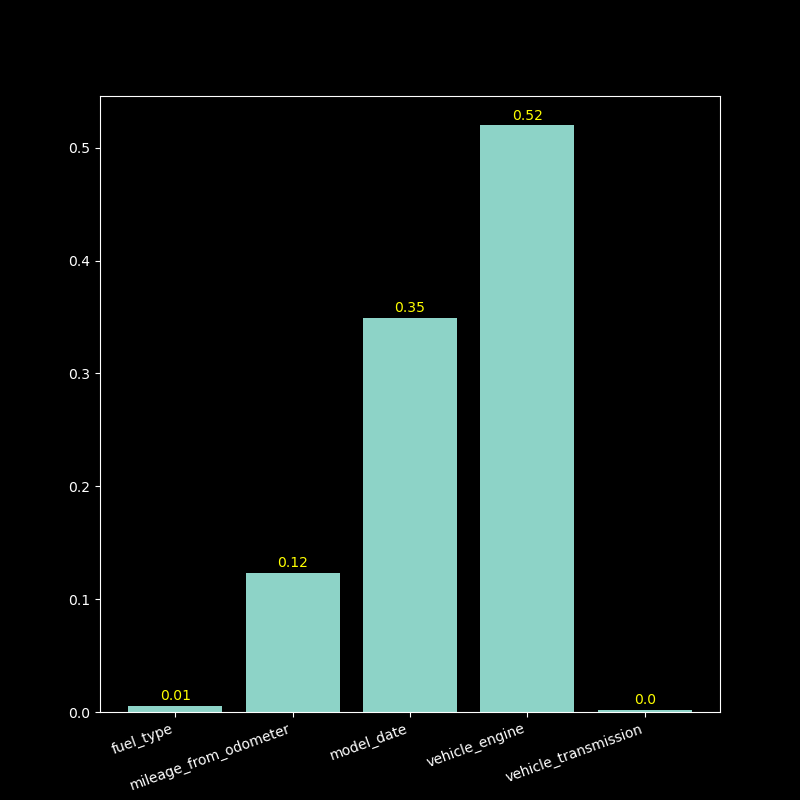

In [113]:
#取得變數重要度
reg=RandomForestRegressor(n_estimators=100,criterion="squared_error",max_features=1.0,max_samples=None,max_leaf_nodes=None,max_depth=None,
                          min_samples_split=2,min_samples_leaf=1,min_weight_fraction_leaf=0.0,min_impurity_decrease=0.0,
                          bootstrap=True,oob_score=False,n_jobs=None,random_state=None,warm_start=False,ccp_alpha=0.0)
reg.fit(X_train_standardized,y_train)
print("Train score={}".format(reg.score(X_train_standardized,y_train)))
print("Test score={}".format(reg.score(X_test_standardized,y_test)))
########################################################################################################################################################################
x_value=["fuel_type","mileage_from_odometer","model_date","vehicle_engine","vehicle_transmission"]
y_value=reg.feature_importances_
########################################################################################################################################################################
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.bar(range(len(x_value)),y_value)
ax.set_xticks(range(len(x_value)),labels=x_value)
plt.setp(ax.get_xticklabels(),rotation=20,ha="right")
for i in range(len(x_value)):
    ax.text(x=i,y=y_value[i]+0.005,s=str(np.round(y_value[i],decimals=2)),ha="center",c="yellow")

In [114]:
#觀察預測結果
from ipywidgets import interact
def show(n):
    reg=RandomForestRegressor(n_estimators=100,criterion="squared_error",max_features=1.0,max_samples=None,max_leaf_nodes=None,max_depth=None,
                              min_samples_split=2,min_samples_leaf=1,min_weight_fraction_leaf=0.0,min_impurity_decrease=0.0,
                              bootstrap=True,oob_score=False,n_jobs=None,random_state=None,warm_start=False,ccp_alpha=0.0)
    reg.fit(X_train_standardized,y_train)
    print("The predicted price={}".format(np.round(reg.predict(X_test_standardized[n:n+1]),decimals=0)))
    print("The actual price={}".format(y_test[n]))
interact(show,n=(0,1999))

interactive(children=(IntSlider(value=999, description='n', max=1999), Output()), _dom_classes=('widget-intera…

<function __main__.show(n)>